# Big Data in Biology
## Workshop for PearlHacks2019

## [Slides Here](https://docs.google.com/presentation/d/1gAi3lR_GV-1tzTgNP8-laJOI43yW75y3iVIzPi0pkns/edit?usp=sharing)

In [58]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 1.3MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 18.3MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/95/a9/4f25a14d23f0786b64875b91784607c2277eff25d48f915e39ff0cff505a/oauth2client-4.1.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e5/7d/9d5a640c4f8bf2c8b1afc015e9a9d8de32e13c9016dcc4b0ec03481fb396/uritemplate-3.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/33/49/c814d6d438b823441552198f096fcd0377fd6c88714dbed34f1d3c8c4389/google_auth_httplib2-0.0.3-py2.py3-none-any.whl
    100% |████████████████████████████████| 81kB 2.0MB/s ta 0:00:01
    100% |████████████████████████████████| 225kB 3.5MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/02/e5/38518af393f7c214357079ce67a317307936896e961e35450b70fad2a9cf/rsa-4.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 81kB 2.0MB/s ta 0:00:01
    100% |███

In [60]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
from google.colab import auth

In [62]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

NameError: name 'auth' is not defined

In [46]:
import tensorflow as tf
import keras
import numpy as np
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt

import random, sys, os, argparse, json
import pandas as pd
from datacontainer import DataContainer

# Read in the Data

In [47]:
# this function will help us get the data into a format we can work with and load into the DataContainer
def load_data(num_samples_json, gtex_gct_flt):
    sample_count_dict = {}
    with open(num_samples_json) as f:
        sample_count_dict = json.load(f)

    idx = 0
    data = {}

    for k in sorted(sample_count_dict.keys()):
        data[k] = gtex_gct_flt[:,idx:(idx + int(sample_count_dict[k]))]
        idx = idx + int(sample_count_dict[k])

    return data

In [48]:
gtex_gct_flt = np.load('./data/gtex_gct_data_float_v7.npy')
total_gene_list = np.load('./data/gtex_gene_list_v7.npy')
data = load_data('./data/gtex_tissue_count_v7.json', gtex_gct_flt)

# Basic EDA

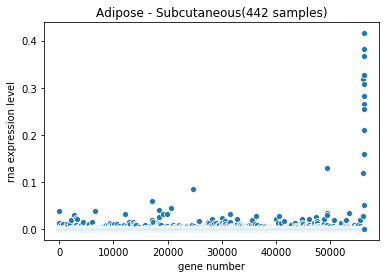

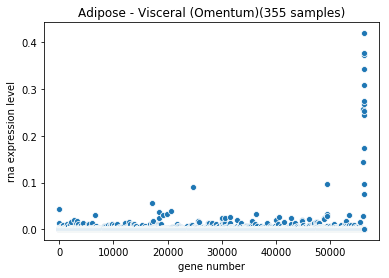

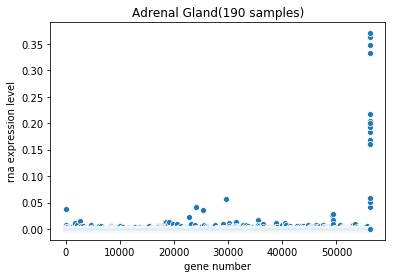

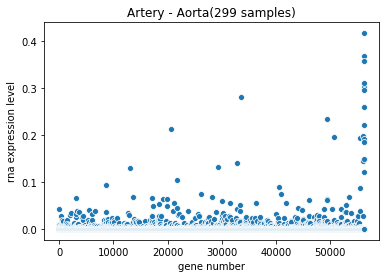

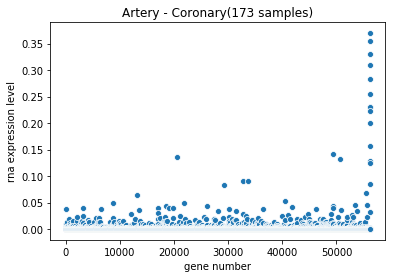

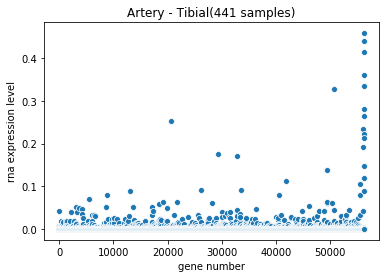

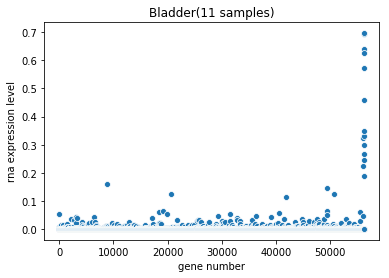

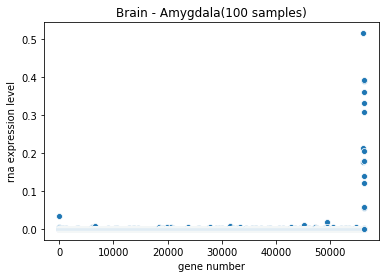

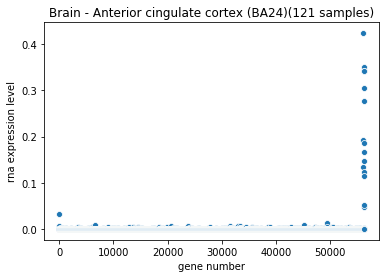

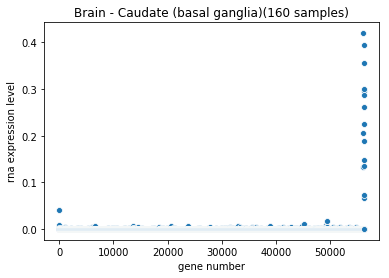

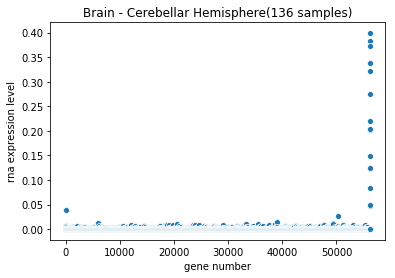

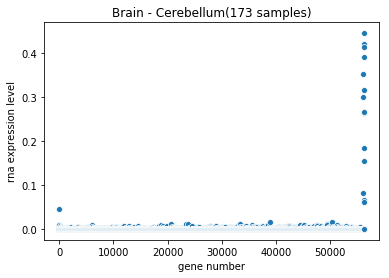

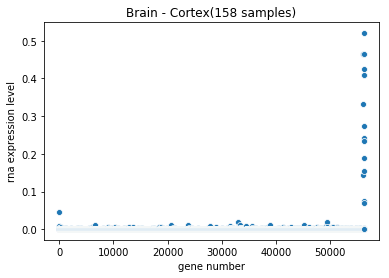

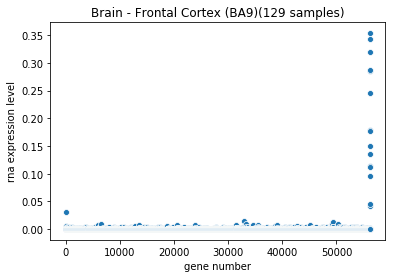

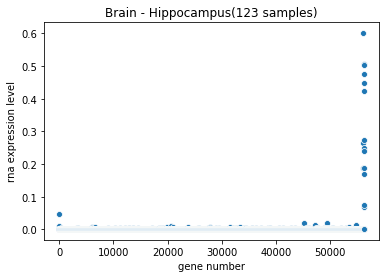

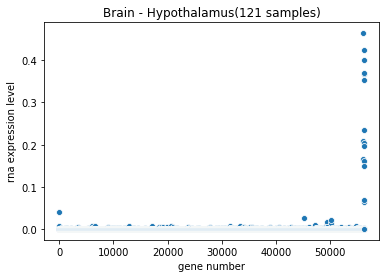

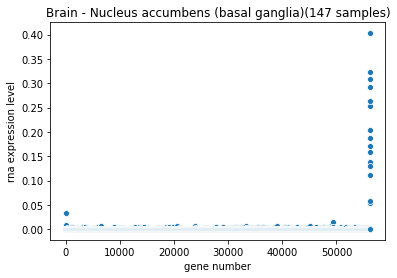

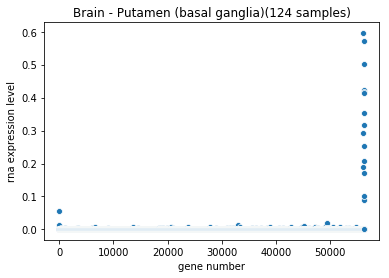

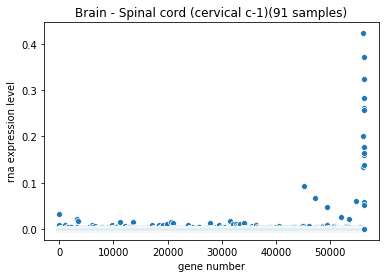

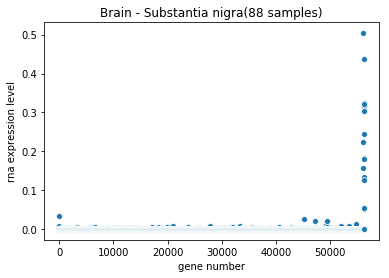

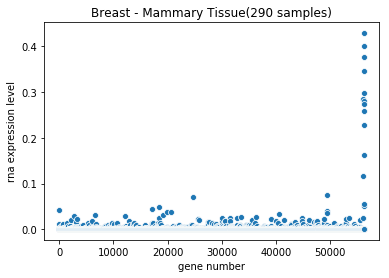

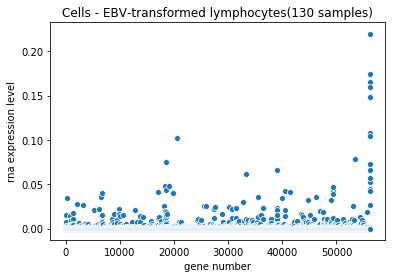

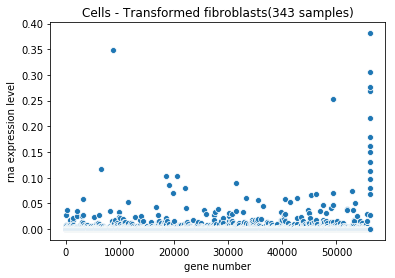

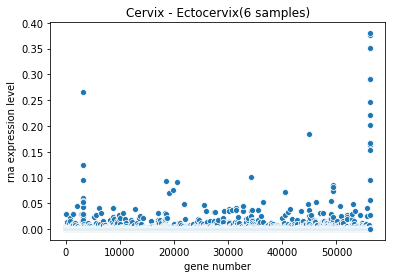

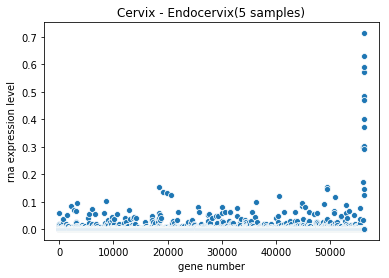

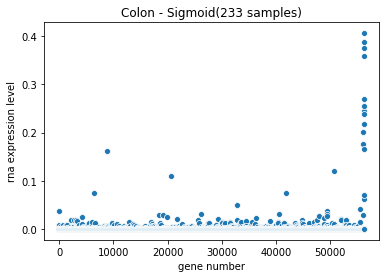

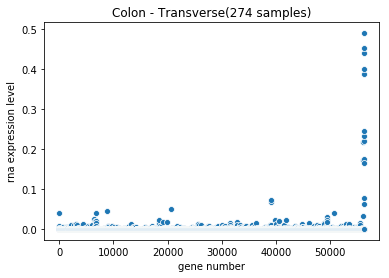

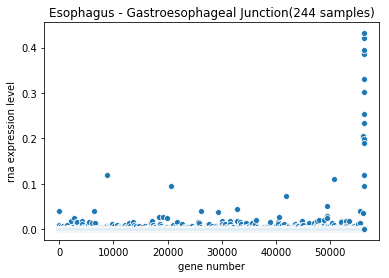

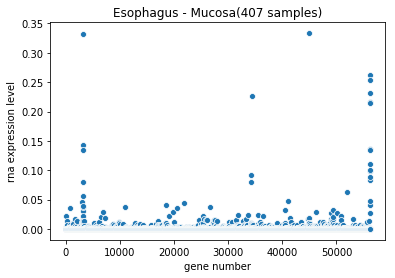

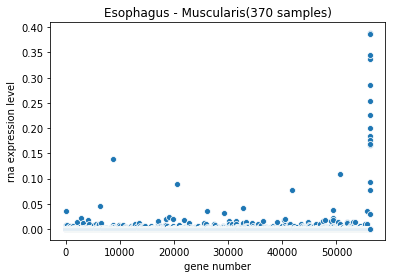

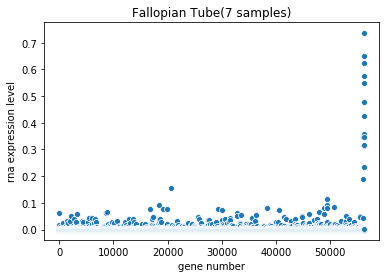

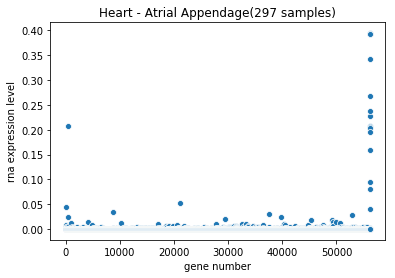

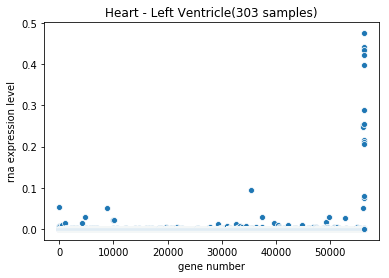

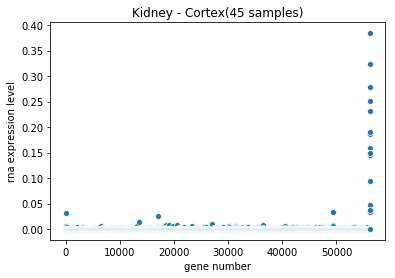

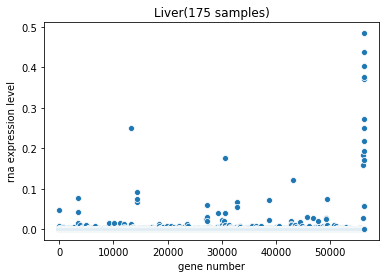

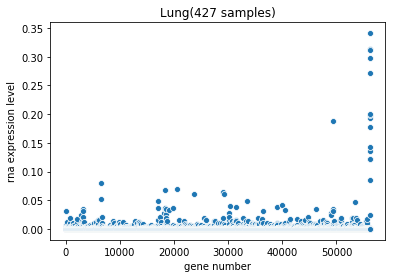

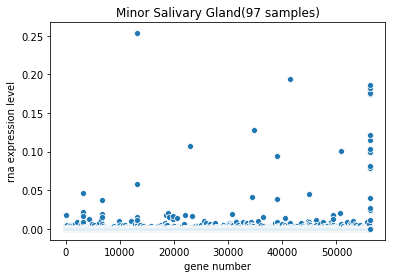

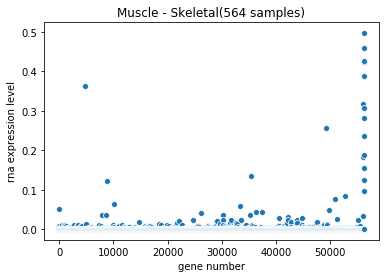

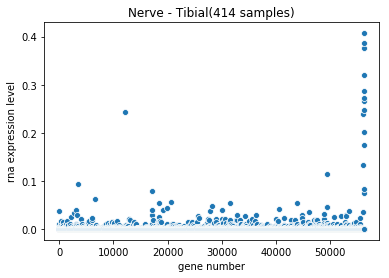

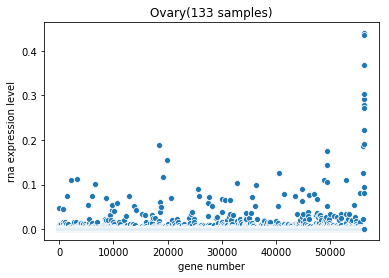

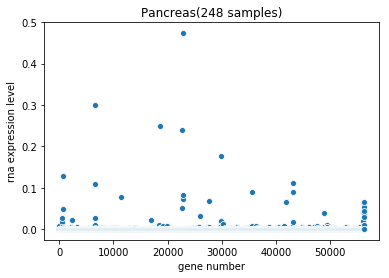

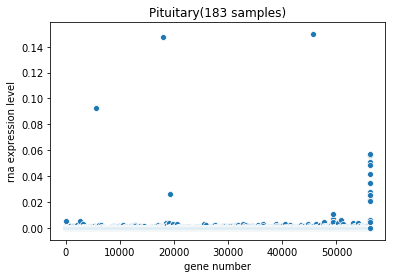

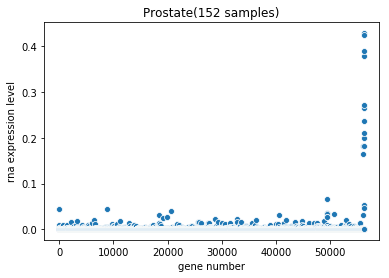

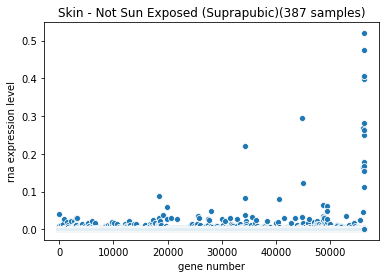

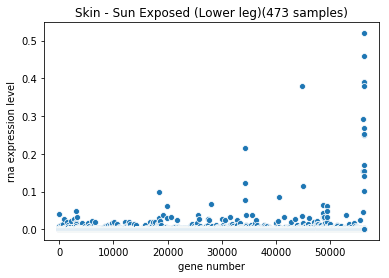

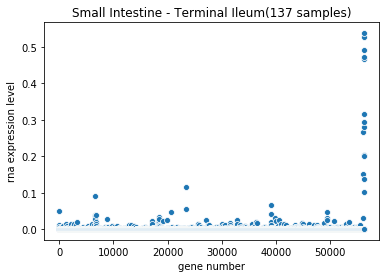

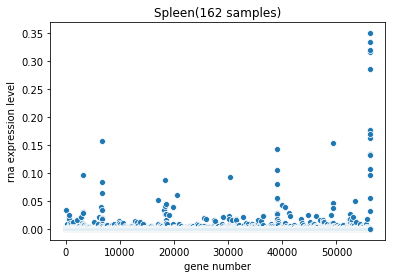

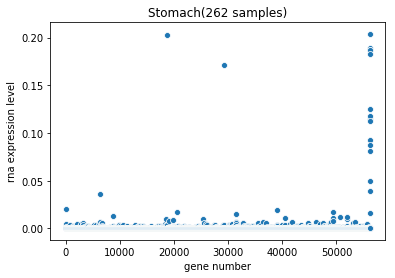

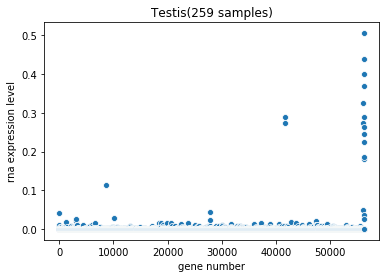

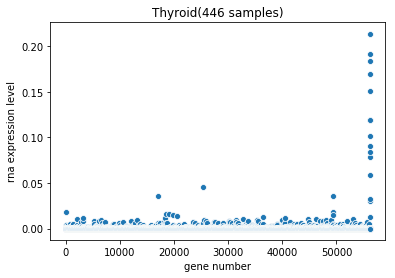

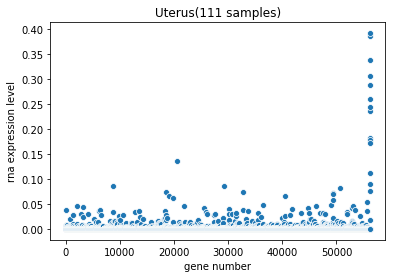

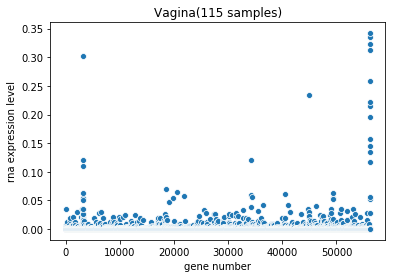

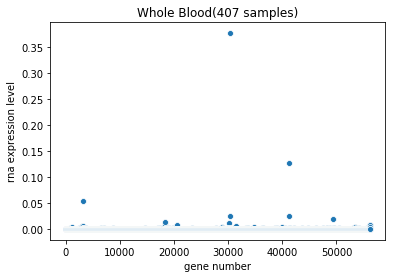

In [49]:
gene_nums = list(range(len(total_gene_list)))
tissue_dict = {}

for tissue in data.keys():
    rna_expression = []
    tissue_max = np.amax(data[tissue])
    for sample in data[tissue]:
        rna_expression.append(np.mean(sample)/tissue_max)  
    sns.scatterplot(x=gene_nums, y=rna_expression)
    plt.title(tissue + "(" + str(len(data[tissue][0])) + " samples)")
    tissue_dict[tissue] = len(data[tissue][0])
    plt.ylabel('rna expression level')
    plt.xlabel('gene number')
    plt.show()

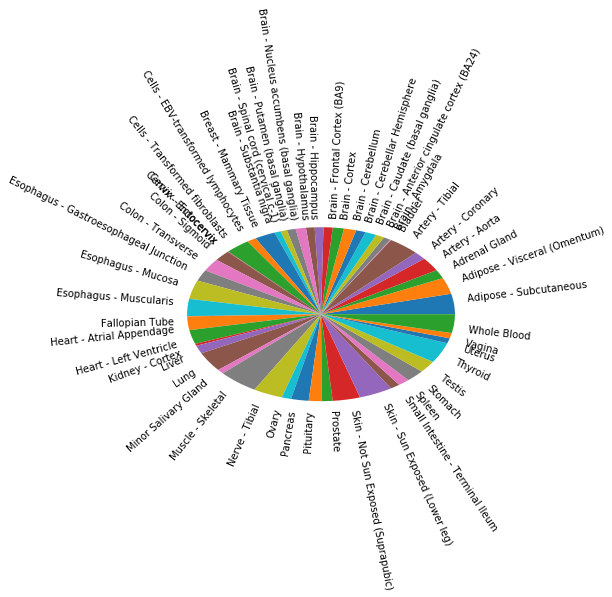

In [57]:
# Plot
plt.pie(tissue_dict.values(), labels=tissue_dict.keys(), rotatelabels=True)
plt.show()

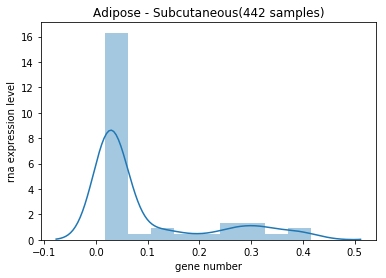

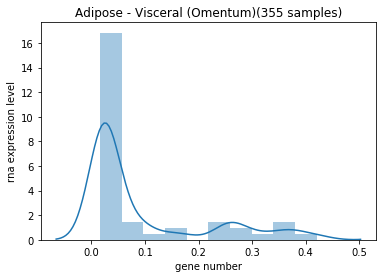

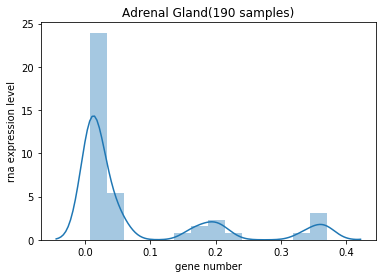

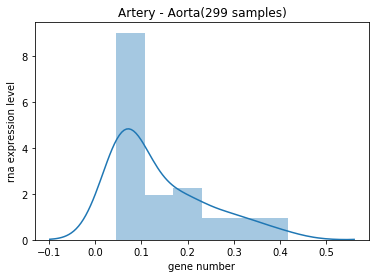

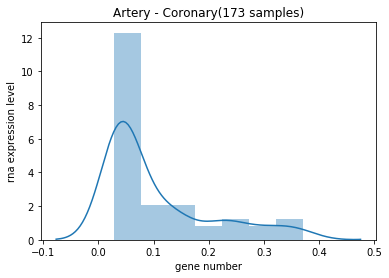

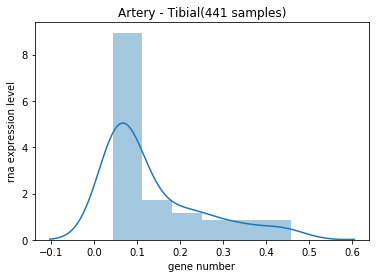

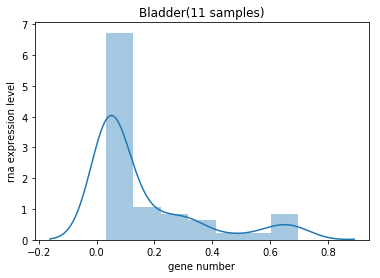

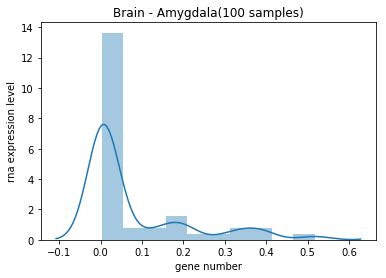

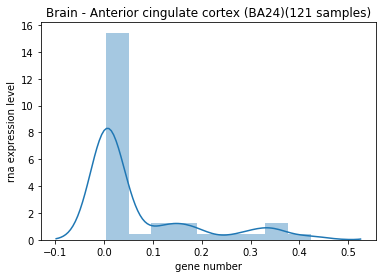

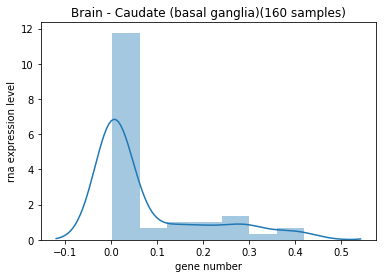

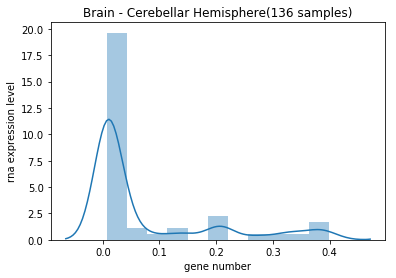

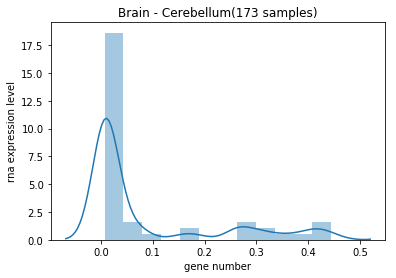

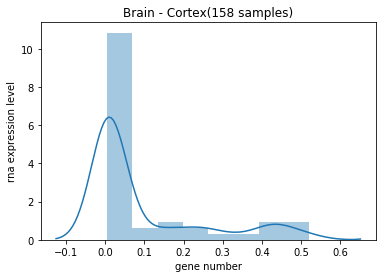

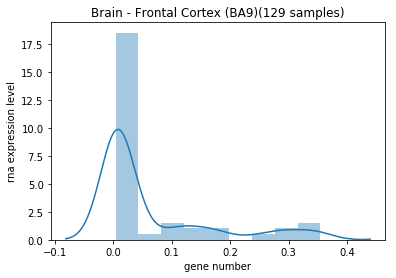

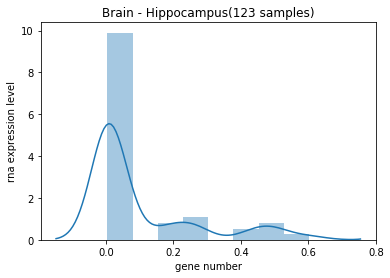

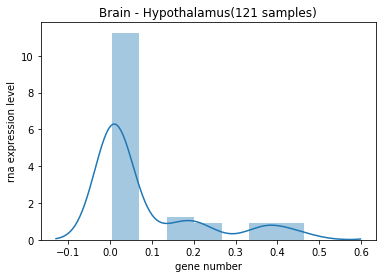

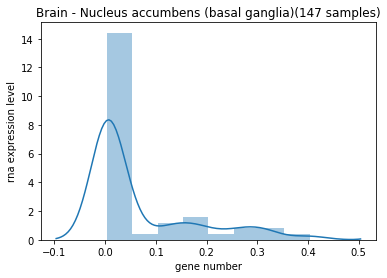

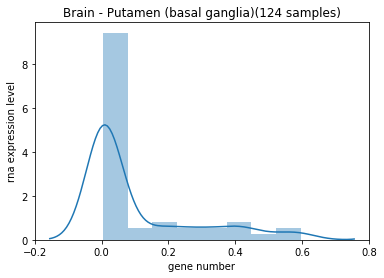

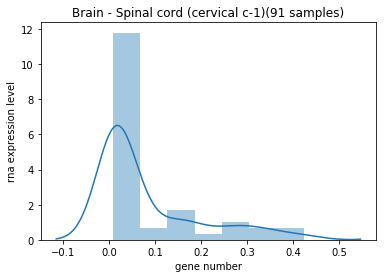

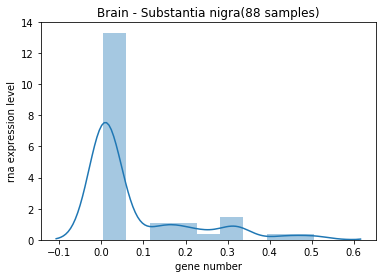

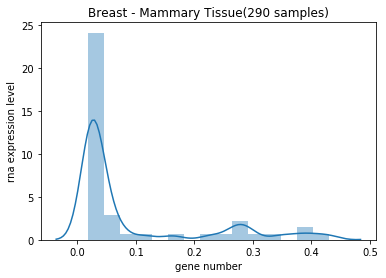

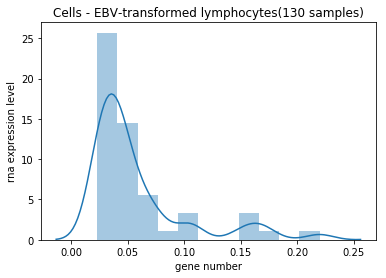

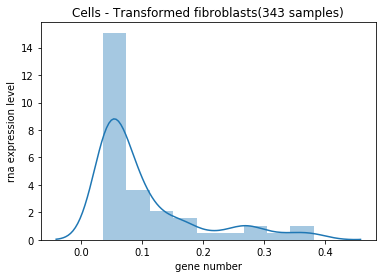

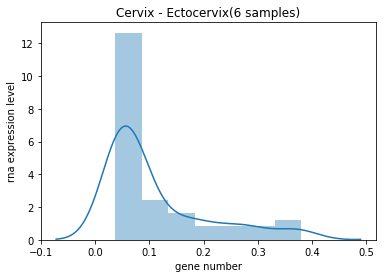

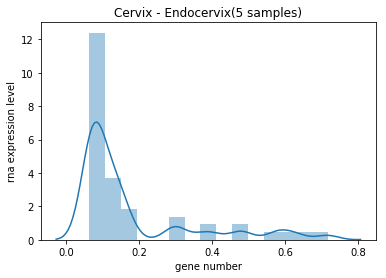

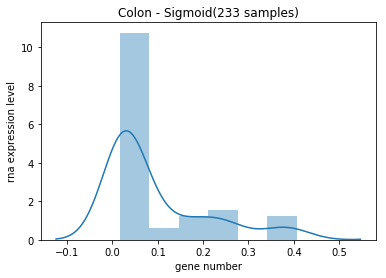

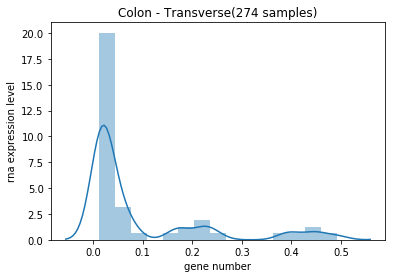

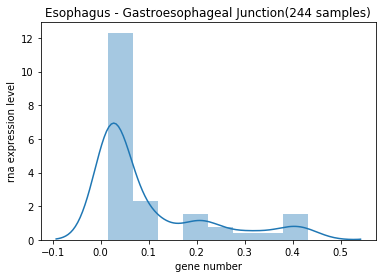

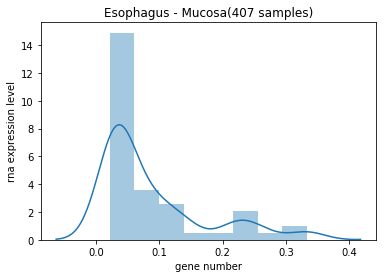

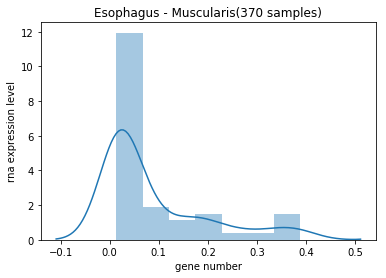

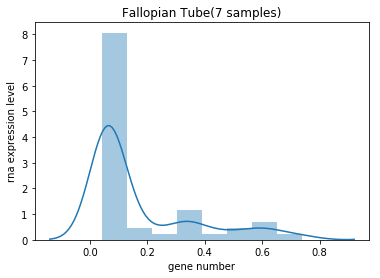

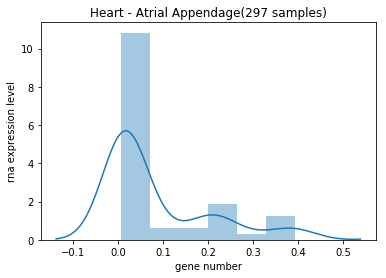

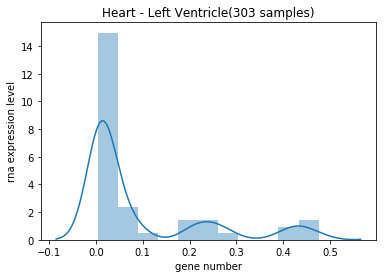

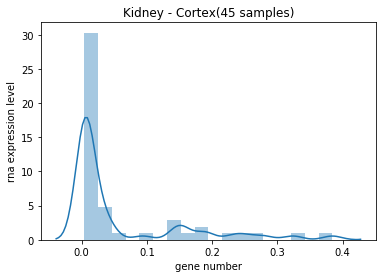

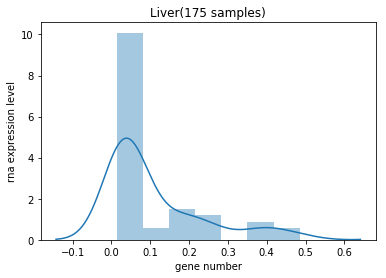

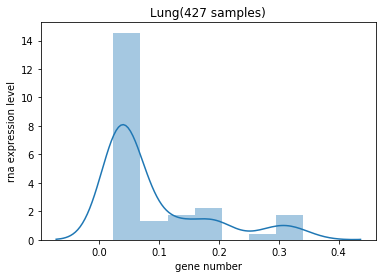

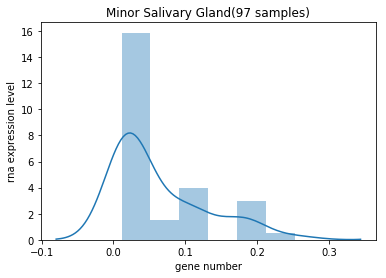

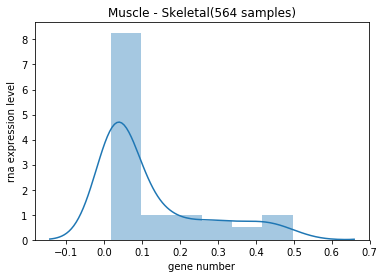

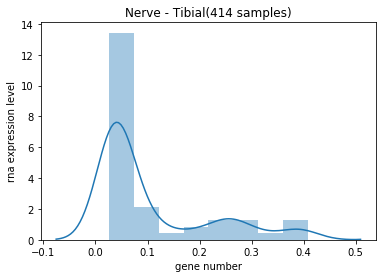

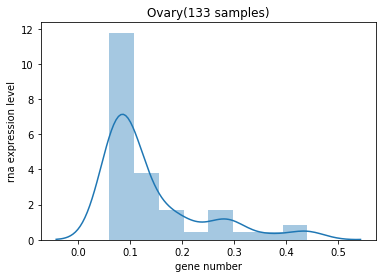

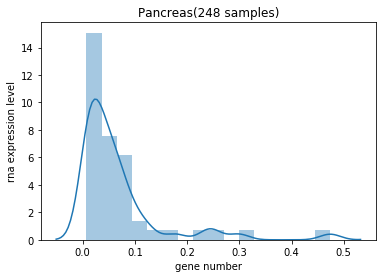

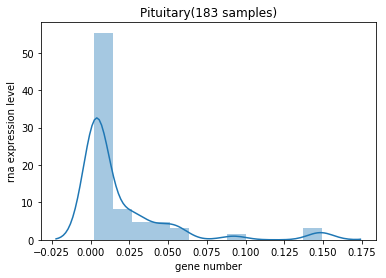

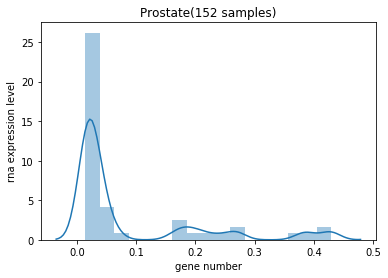

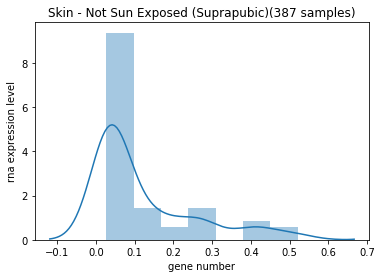

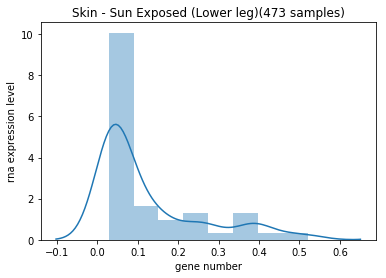

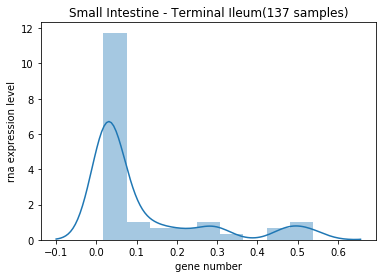

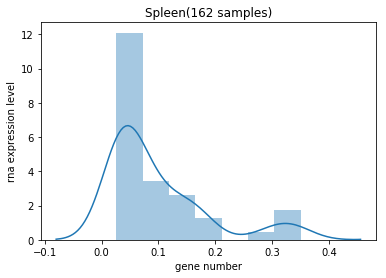

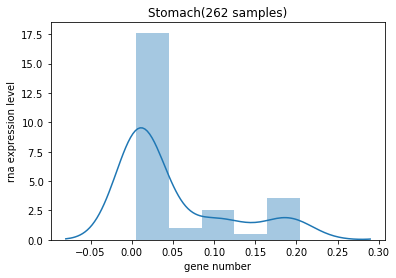

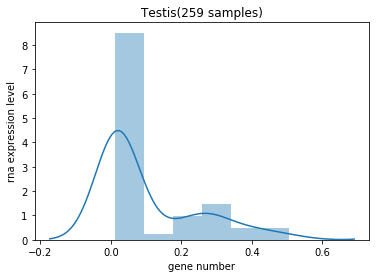

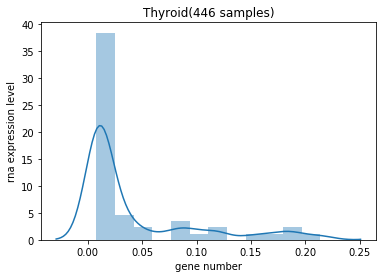

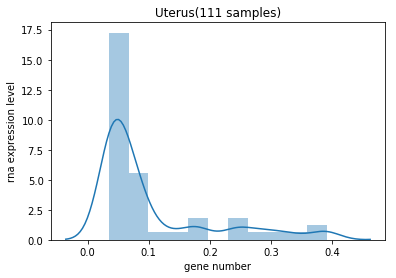

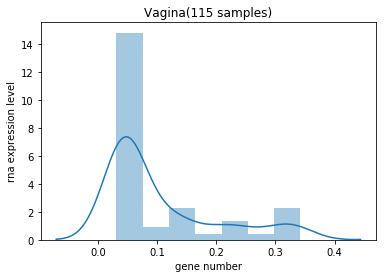

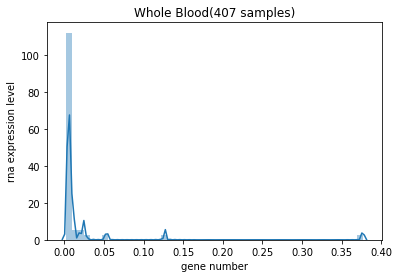

In [50]:
for tissue in data.keys():
    rna_expression = []
    tissue_max = np.amax(data[tissue])
    for sample in data[tissue]:
        rna_expression.append(np.mean(sample)/tissue_max) 
    length = len(sorted(rna_expression))
    sns.distplot(sorted(rna_expression)[length-50: length])
    plt.title(tissue + "(" + str(len(data[tissue][0])) + " samples)")
    plt.ylabel('rna expression level')
    plt.xlabel('gene number')
    plt.show()  

In [39]:
# make a scatter plot with all the data(top 50 genes) 
# need to readjust the tissue max
# make hue for the tissue types
# pie chart
maxs = [ np.amax(d) for d in data.values() ]
overall_max = max(maxs)
overall_max

53

In [ ]:
df = pd.DataFrame(columns = ['Tissue_Type', 'REL'])
df

for tissue in data.keys():
    rna_expression = []
    tissue_max = np.amax(data[tissue])
    for sample in data[tissue]:
        rna_expression.append(np.mean(sample)/overall_max) 
    length = len(sorted(rna_expression))
    for rel in sorted(rna_expression)[length-50: length]:
        df = df.append({'Tissue_Type':tissue,'REL': rel}, ignore_index=True)

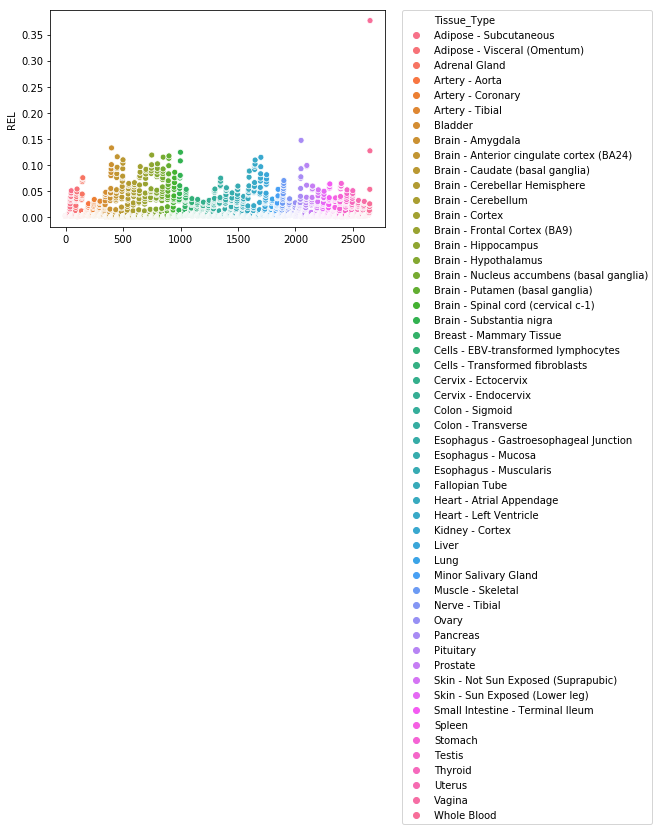

In [44]:
g = sns.scatterplot( x=df.index, y = "REL" ,hue="Tissue_Type",data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [51]:
# df = pd.DataFrame(columns = ['Tissue_Type', 'REL'])
# df

# for tissue in data.keys():
#     for sample in data[tissue]:
#         df = df.append({'Tissue_Type':tissue,'REL': np.mean(sample)/overall_max}, ignore_index=True)


# Supervised Learning: MLP¶

Let's build a neural network to perform classification on the our RNAseq dataset. As it turns out, scikit-learn actually has an MLPClassifier, but we need something that will run on a GPU -- trust me, we're going to need the extra compute power later on. From now on we're going to use two Python libraries, Tensorflow and Keras. Tensorflow is a GPU-accelerated framework for creating and running neural networks, and Keras is a thin wrapper over Tensorflow which provides a much simpler interface (Keras also supports other backends aside from Tensorflow). In short, we will use Keras, but just know that Tensorflow is doing all of the hard work behind the scenes. Now let's make a network:

In [6]:
# we are now going to load the data into the DataContainer object so we can easily access it...
dataset = DataContainer(data, total_gene_list)

In [7]:
# let's define some metavariables we might use later...
num_classes = len(data) # data variable is a dictionary with each key being a class
num_genes = dataset.train.data.shape[-1] # train.data is num_samples x num_genes

In [8]:
# now it is time to create our model, preprocess our data, and get classifying
# create a neural network with three hidden layers
mlp = keras.models.Sequential()
mlp.add(keras.layers.Dense(units=1024, activation="relu", input_shape=(num_genes,))) 
mlp.add(keras.layers.Dense(units=512, activation="relu"))
mlp.add(keras.layers.Dense(units=128, activation="relu"))
mlp.add(keras.layers.Dense(units=num_classes, activation="softmax"))

In [9]:
# lets compile the model and check out the stats
# compile the model
mlp.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# print a summary of the model
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              57551872  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 53)                6837      
Total params: 58,149,173
Trainable params: 58,149,173
Non-trainable params: 0
_________________________________________________________________


In [10]:
# lets do a little preprocessing, then fit the model
scaler = preprocessing.MinMaxScaler() #preprocessing.MaxAbsScaler()
dataset.train.data = scaler.fit_transform(dataset.train.data)
dataset.test.data = scaler.fit_transform(dataset.test.data)

In [11]:
# train the model
history = mlp.fit(x=dataset.train.data, y=dataset.train.labels, batch_size=128, epochs=10, validation_split=0.1)

Train on 7341 samples, validate on 816 samples
Epoch 1/10
7341/7341 [==============================] - 57s 8ms/step - loss: 1.7497 - acc: 0.6129 - val_loss: 0.5170 - val_acc: 0.8113
Epoch 2/10
7341/7341 [==============================] - 52s 7ms/step - loss: 0.3415 - acc: 0.8965 - val_loss: 0.2903 - val_acc: 0.9118
Epoch 3/10
7341/7341 [==============================] - 53s 7ms/step - loss: 0.1732 - acc: 0.9534 - val_loss: 0.2200 - val_acc: 0.9363
Epoch 4/10
7341/7341 [==============================] - 54s 7ms/step - loss: 0.1000 - acc: 0.9751 - val_loss: 0.1885 - val_acc: 0.9400
Epoch 5/10
7341/7341 [==============================] - 53s 7ms/step - loss: 0.0587 - acc: 0.9864 - val_loss: 0.1680 - val_acc: 0.9534
Epoch 6/10
7341/7341 [==============================] - 53s 7ms/step - loss: 0.0403 - acc: 0.9896 - val_loss: 0.2174 - val_acc: 0.9179
Epoch 7/10
7341/7341 [==============================] - 53s 7ms/step - loss: 0.0250 - acc: 0.9941 - val_loss: 0.1280 - val_acc: 0.9620
Epoch 8/

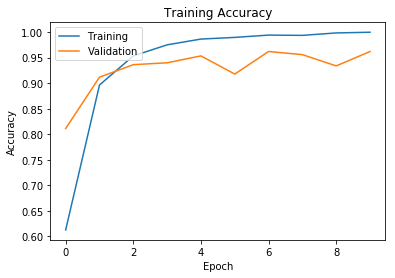

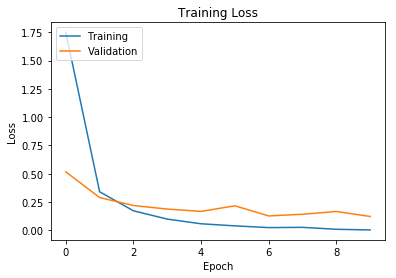

In [12]:
# plot the training accuracy
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Training Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()

# plot the training loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()

In [13]:
# evaluate the model on the test set
scores = mlp.evaluate(x=dataset.test.data, y=dataset.test.labels)

# print results
for name, score in zip(mlp.metrics_names, scores):
    print("%s: %g" % (name, score))

3531/3531 [==============================] - 5s 1ms/step
loss: 0.179225
acc: 0.955253
